# 03. PyTorch Computer Vision Exercises

The following is a collection of exercises based on computer vision fundamentals in PyTorch.

They're a bunch of fun.

You're going to get to write plenty of code!

## Resources

1. These exercises are based on [notebook 03 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/03_pytorch_computer_vision/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/_PibmqpEyhA).
  * **Note:** Going through these exercises took me just over 3 hours of solid coding, so you should expect around the same.
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [2]:
# Check for GPU
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [3]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# TODO: Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.5.1+cu124


'cpu'

## 1. What are 3 areas in industry where computer vision is currently being used?

Automotive industry, detecting defaillances in products and in the medical industry

## 2. Search "what is overfitting in machine learning" and write down a sentence about what you find.

Overfitting in machine learning occurs when a model learns the training data too well, capturing noise and details to the extent that it negatively impacts the model's performance on new, unseen data. Essentially, the model becomes overly complex and tailored to the training set, losing its ability to generalize.

## 3. Search "ways to prevent overfitting in machine learning"

Cross-Validation: Use techniques like k-fold cross-validation to evaluate the model's performance on multiple subsets of the data.

Simplify the Model: Reduce the number of features or use a simpler model architecture.

Regularization: Apply regularization techniques (e.g., L1, L2, or dropout in neural networks) to penalize overly complex models.

Increase Training Data: Collect more data to help the model generalize better.

Early Stopping: Stop training when the model's performance on the validation set starts to degrade.

Pruning: In decision trees, remove branches that have little importance.

Ensemble Methods: Use techniques like bagging (e.g., Random Forests) or boosting to improve generalization.

## 4. Spend 20-minutes reading and clicking through the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/).

* Upload your own example image using the "upload" button on the website and see what happens in each layer of a CNN as your image passes through it.

## 5. Load the [`torchvision.datasets.MNIST()`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) train and test datasets.

In [4]:
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

# Setup training data
train_data = datasets.MNIST(
    root="data", # where to download data to?
    train=True, # get training data
    download=True, # download data if it doesn't exist on disk
    transform=ToTensor(), # images come as PIL format, we want to turn into Torch tensors
    target_transform=None # you can transform labels as well
)

# Setup testing data
test_data = datasets.MNIST(
    root="data",
    train=False, # get test data
    download=True,
    transform=ToTensor()
)

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 9.91M/9.91M [00:00<00:00, 75.4MB/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 28.9k/28.9k [00:00<00:00, 23.0MB/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>




100%|██████████| 1.65M/1.65M [00:00<00:00, 44.4MB/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
<urlopen error [Errno 111] Connection refused>



100%|██████████| 4.54k/4.54k [00:00<00:00, 8.09MB/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



## 6. Visualize at least 5 different samples of the MNIST training dataset.

In [5]:
image, label = train_data[0]
image.shape

torch.Size([1, 28, 28])

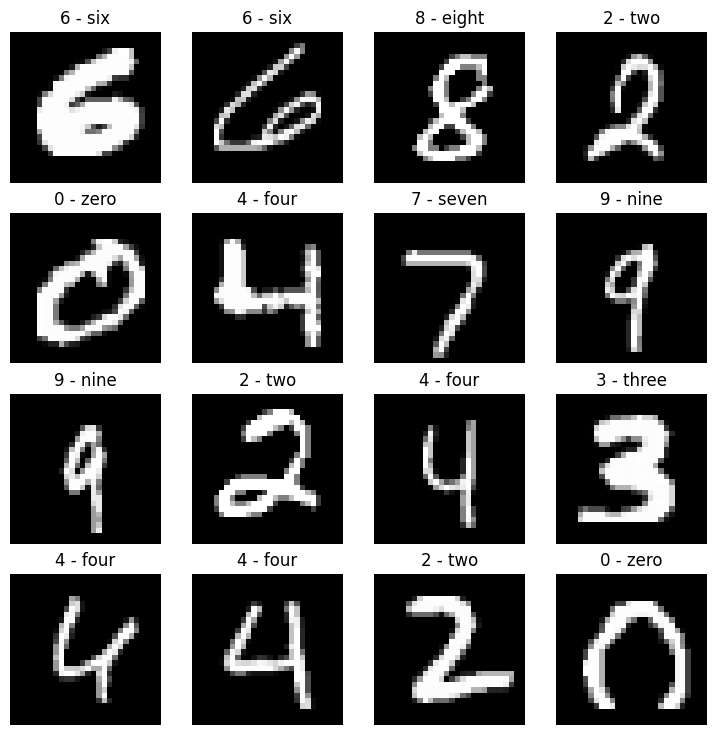

In [6]:
import matplotlib.pyplot as plt

torch.manual_seed(42)
class_names = train_data.classes
fig = plt.figure(figsize=(9, 9))
rows, cols = 4, 4
for i in range(1, rows * cols + 1):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(class_names[label])
    plt.axis(False);

## 7. Turn the MNIST train and test datasets into dataloaders using `torch.utils.data.DataLoader`, set the `batch_size=32`.

In [7]:
from torch.utils.data import DataLoader

# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, # dataset to turn into iterable
    batch_size=BATCH_SIZE, # how many samples per batch?
    shuffle=True # shuffle data every epoch?
)

test_dataloader = DataLoader(test_data,
    batch_size=BATCH_SIZE,
    shuffle=False # don't necessarily have to shuffle the testing data
)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f4d46f2f3d0>, <torch.utils.data.dataloader.DataLoader object at 0x7f4d46da08d0>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [8]:
for sample in next(iter(train_dataloader)):
  print(sample.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


## 8. Recreate `model_2` used in notebook 03 (the same model from the [CNN Explainer website](https://poloclub.github.io/cnn-explainer/), also known as TinyVGG) capable of fitting on the MNIST dataset.

In [9]:
class TinyVGG(nn.Module):
  def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
    super().__init__()

    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2))

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
    )


  def forward(self, x:torch.Tensor):
    x = self.block1(x)
    x = self.block2(x)
    x = self.classifier(x)
    return x

torch.manual_seed(42)

"""model_cpu = TinyVGG(input_shape=1,
    hidden_units=10,
    output_shape=len(class_names))"""
model_gpu = TinyVGG(1,10,len(class_names)).to(device)


In [10]:
model_gpu

TinyVGG(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

## 9. Train the model you built in exercise 8. for 5 epochs on CPU and GPU and see how long it takes on each.

In [11]:

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_gpu.parameters(),
                             lr=0.1)

In [33]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y,
                                 y_pred=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")


def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode():
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred = model(X)

            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )

        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [13]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

In [14]:
from tqdm.auto import tqdm

from timeit import default_timer as timer
train_time_start_on_gpu = timer()

NUM_EPOCHS = 5

for epoch in tqdm(range(NUM_EPOCHS)):
  train_step(model_gpu, train_dataloader, loss_fn, optimizer, accuracy_fn, device)
  test_step(test_dataloader, model_gpu, loss_fn, accuracy_fn, device)


  0%|          | 0/5 [00:00<?, ?it/s]

Train loss: 0.26560 | Train accuracy: 91.33%
Test loss: 0.07672 | Test accuracy: 97.57%

Train loss: 0.06840 | Train accuracy: 97.84%
Test loss: 0.04390 | Test accuracy: 98.55%

Train loss: 0.05379 | Train accuracy: 98.38%
Test loss: 0.04583 | Test accuracy: 98.52%

Train loss: 0.04419 | Train accuracy: 98.58%
Test loss: 0.04233 | Test accuracy: 98.57%

Train loss: 0.03947 | Train accuracy: 98.71%
Test loss: 0.03516 | Test accuracy: 98.78%



In [35]:
y_preds

NameError: name 'y_preds' is not defined

## 10. Make predictions using your trained model and visualize at least 5 of them comparing the prediciton to the target label.

In [15]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 1, so can perform on dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())

    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [16]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


In [18]:
# Make predictions on test samples with model 2
pred_probs= make_predictions(model=model_gpu,
                             data=test_samples)

# View first two prediction probabilities list
pred_probs[:2]

tensor([[1.3173e-10, 7.4633e-08, 9.9999e-01, 1.6588e-07, 1.3207e-14, 3.0294e-15,
         4.9383e-13, 3.3799e-09, 1.4159e-05, 3.3822e-10],
        [9.3765e-09, 9.9886e-01, 8.9309e-07, 1.2782e-06, 2.1158e-05, 5.4485e-04,
         4.2278e-05, 3.9319e-07, 4.9055e-04, 3.8080e-05]])

In [19]:
# Turn the prediction probabilities into prediction labels by taking the argmax()
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

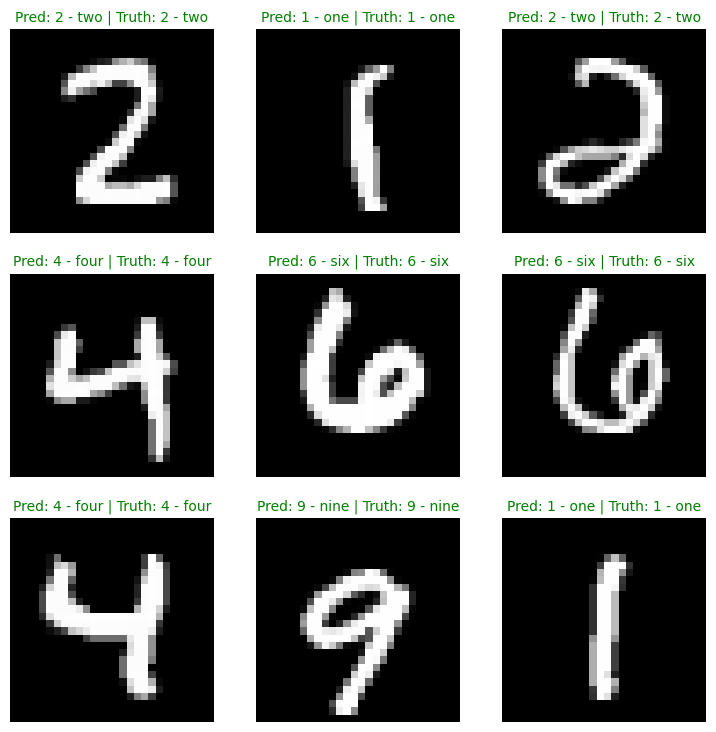

In [20]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = class_names[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = class_names[test_labels[i]]

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"

  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

## 11. Plot a confusion matrix comparing your model's predictions to the truth labels.

In [22]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
    assert int(mlxtend.__version__.split(".")[1]) >= 19, "mlxtend verison should be 0.19.0 or higher"
except:
    !pip install -q torchmetrics -U mlxtend # <- Note: If you're using Google Colab, this may require restarting the runtime
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [38]:
# 1. Make predictions with trained model
y_preds = []
model_gpu.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    # Send data and targets to target device
    X, y = X.to(device), y.to(device)
    # Do the forward pass
    y_logit = model_gpu(X)
    # Turn predictions from logits -> prediction probabilities -> predictions labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) # note: perform softmax on the "logits" dimension, not "batch" dimension (in this case we have a batch size of 32, so can perform on dim=1)
    # Put predictions on CPU for evaluation
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions:   0%|          | 0/313 [00:00<?, ?it/s]

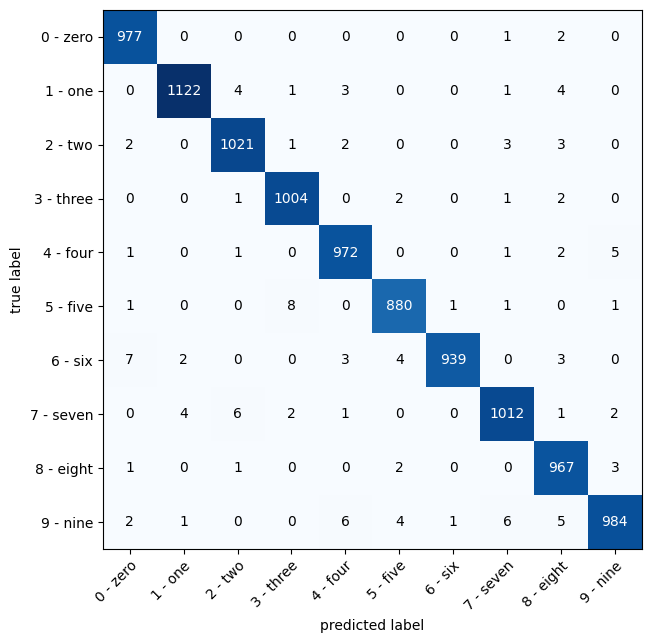

In [39]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# 2. Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

# 3. Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);